In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from prettytable import PrettyTable
from statistics import mean, median, mode
import time

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

C:\Users\Yzabelle\miniconda3\envs\tf\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


Note: Below is to determine if a GPU is on the device, if not, the model will run on the CPU

In [2]:
DEVICE_NAME = tf.test.gpu_device_name()
if len(DEVICE_NAME) > 0:
    print("Found GPU at: {}".format(DEVICE_NAME))
    !nvidia-smi
else:
    DEVICE_NAME = "/device:CPU:0"
    print("No GPU, using {}.".format(DEVICE_NAME))

Found GPU at: /device:GPU:0
Thu Apr  6 16:29:10 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.41                 Driver Version: 531.41       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070       WDDM | 00000000:2B:00.0  On |                  N/A |
|  0%   46C    P2               52W / 220W|   1572MiB /  8192MiB |      6%      Default |
|                                         |                      |                  N/A |
+---------------------------------------

Note: Below finds the words.txt file in local files -> words.txt contains info about each image, most importantly the label for what the image says -> this info is saved in list_of_words 

In [3]:
script_dir = os.path.abspath('') 
rel_path = "data/words.txt"
text_file = os.path.join(script_dir, rel_path)
rel_folder_path = 'data/words/'
image_file = os.path.join(script_dir, rel_folder_path)

list_of_words = []
label_file = open(text_file, 'r').readlines()

for line in label_file:
    # ignore commented lines
    if line[0] == "#":
        continue
    # only get "ok" entries
    if line.split(" ")[1] == "ok":
        list_of_words.append(line)  

# total number of words in the dataset we will be working with
print(f"Total words: {len(list_of_words)}")
print(list_of_words[:10])

Total words: 96456
['a01-000u-00-00 ok 154 408 768 27 51 AT A\n', 'a01-000u-00-01 ok 154 507 766 213 48 NN MOVE\n', 'a01-000u-00-02 ok 154 796 764 70 50 TO to\n', 'a01-000u-00-03 ok 154 919 757 166 78 VB stop\n', 'a01-000u-00-04 ok 154 1185 754 126 61 NPT Mr.\n', 'a01-000u-00-05 ok 154 1438 746 382 73 NP Gaitskell\n', 'a01-000u-00-06 ok 154 1896 757 173 72 IN from\n', 'a01-000u-01-00 ok 156 395 932 441 100 VBG nominating\n', 'a01-000u-01-01 ok 156 901 958 147 79 DTI any\n', 'a01-000u-01-02 ok 156 1112 958 208 42 AP more\n']


Note: here we split our full list of words into train/test/validate sets, using ratios defined below 
Can see how many elements are in each set as well

In [4]:
TRAIN_RATIO = 0.9
VAL_RATIO = 0.5

training_data = []
validation_data = []
testing_data = []

# split data into training, testing, validation sets
total_words = len(list_of_words)
training_indexes = int(TRAIN_RATIO * total_words)
split_test_and_val = int(VAL_RATIO * (total_words-training_indexes))
testing_indexes = training_indexes - split_test_and_val
validation_indexes = -split_test_and_val

training_data = list_of_words[:training_indexes]
testing_data = list_of_words[testing_indexes:training_indexes]
validation_data = list_of_words[validation_indexes:]


print(f"Train/Val/Test: {len(training_data)}/{len(validation_data)}/{len(testing_data)}")

Train/Val/Test: 86810/4823/4823


Note: just initializing variables we will need later on
    The char list is what one ml layer will be trying to sort different chars into
    longest_label_length is used to help resize the images, and something else
    new_image_size: ...
    batch_size: number of training examples used in 1 iteration -> smaller generally faster, but less accurate
    pad_with_val: fills label vectors with this value so that they are all the same length  

In [5]:
# Init needed variables 
full_char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 
char_array = [c for c in full_char_list]

longest_label_length = 21
new_image_size = (64, 128)

# setting to 99 so it is not associated w a char in the char array
pad_with_val = 99

In [6]:
# todo: comment
def get_data_from_files(data):
    img_paths = []
    img_label = []
    for element in data:
        element = element.strip().split(" ")
        image_name = element[0]
        first_section, second_section = image_name.split("-")[:2]
        img_path = os.path.join(image_file, first_section, f"{first_section}-{second_section}", f"{image_name}.png")
        # using getsize to avoid any 0 size images 
        if os.path.getsize(img_path):
            img_paths.append(img_path)
            img_label.append(element[-1])
    
    return img_paths, img_label

# todo: comment
def encode_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    padding_amount = longest_label_length - tf.shape(label)[0]
    label = tf.pad(label, paddings=[[0, padding_amount]], constant_values=pad_with_val)
    return label

# todo: comment
def preprocess_image(image_path):
    # load image file
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    # scale image to new size
    image = tf.image.resize(image, size=(new_image_size[0], new_image_size[1]), preserve_aspect_ratio=True)
    # add black padding
    image = tf.pad(
        image,
        paddings=[[0, new_image_size[0] - tf.shape(image)[0]], [0, new_image_size[1] - tf.shape(image)[1]], [0, 0]],
    )
    # necessary transposition -> todo: why
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    
    # normalize image 
    image = tf.cast(image, tf.float32) / 255.0
    return image

def format_data(image_path, label):
    image = preprocess_image(image_path)
    label = encode_label(label)
    return {"image": image, "label": label}

def create_ds(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        format_data, num_parallel_calls=tf.data.AUTOTUNE
    )
    return dataset.batch(32).cache().prefetch(tf.data.AUTOTUNE)

In [7]:
char_to_num = StringLookup(vocabulary=list(char_array))
num_to_char = StringLookup(vocabulary=list(char_array), invert=True)

def uncode_label(label):
    indices = tf.gather(label, tf.where(tf.math.not_equal(label, pad_with_val)))
    label = tf.strings.reduce_join(num_to_char(indices))
    label = label.numpy().decode("utf-8")
    
    return label

# todo: 
training_paths, training_labels = get_data_from_files(training_data)
validation_paths, validation_labels = get_data_from_files(validation_data)
testing_paths, testing_labels = get_data_from_files(testing_data)

prepared_training_dataset = create_ds(training_paths, training_labels)
prepared_validation_dataset = create_ds(validation_paths, validation_labels)
prepared_testing_dataset = create_ds(testing_paths, testing_labels)

# todo: 
validation_images = []
validation_labels = []

for batch in prepared_validation_dataset:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

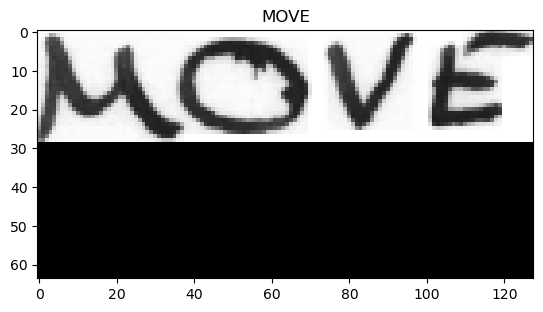

In [8]:
# show sample img + label after processing
for img in prepared_training_dataset.take(1):
    image, label = img["image"][1], img["label"][1]
    image = tf.image.flip_left_right(image)
    image = tf.transpose(image, perm=[1, 0, 2])
    
    label = uncode_label(label)

    plt.imshow(image, cmap=plt.cm.gray)
    plt.title(label)

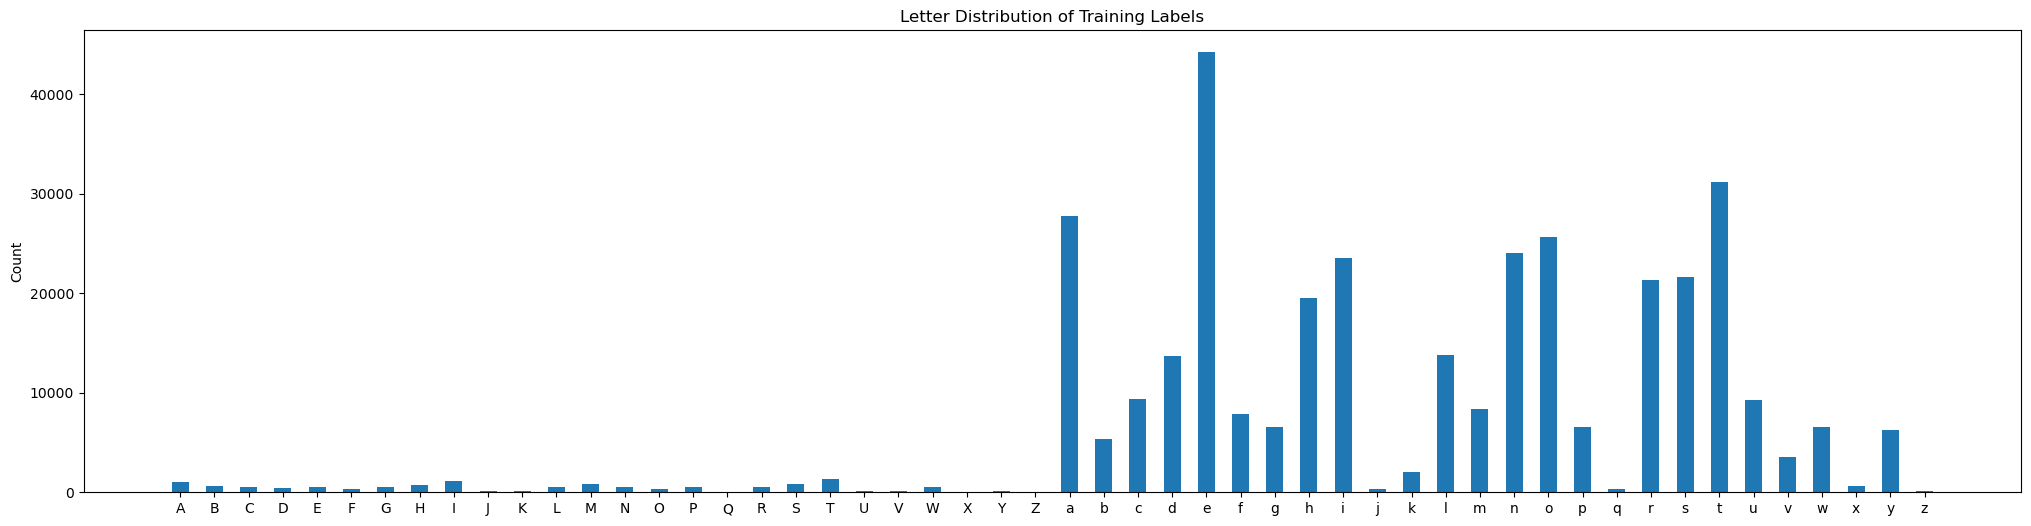

+------------------------------+-------------------+
|      Summary Statistics      |       Value       |
+------------------------------+-------------------+
|         Mean Length          | 4.212489488417099 |
|        Median Length         |         4         |
|         Mode Length          |         3         |
| Total # of Labels in Dataset |       86809       |
+------------------------------+-------------------+


In [9]:
def letter_distribution(labels, title):
    alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
    #Puncuation has been omitted here for clairty in the chart, but the model does account for it
    counts = np.zeros(len(alphabet))
    for label in labels:
        for char in label:
            if char in alphabet:
                index = alphabet.index(char)
                counts[index] += 1
    x = np.arange(len(alphabet))
    fig, ax = plt.subplots(figsize=(25, 6))
    ax.bar(x, counts, width=0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(list(alphabet))
    ax.set_ylabel('Count')
    ax.set_title(f'Letter Distribution of {title} Labels')
    plt.show()
    
def length_stats(labels):
    lengths = [len(label) for label in labels]
    mean_length = mean(lengths)
    median_length = median(lengths)
    mode_length = mode(lengths)
    number_of_labels = len(labels)
    return {'mean': mean_length, 'median': median_length, 'mode': mode_length, 'number_of_labels': number_of_labels}


letter_distribution(training_labels, "Training")
stats = length_stats(training_labels)

table = PrettyTable()
table.field_names = ['Summary Statistics', 'Value']
table.add_row(['Mean Length', stats['mean']])
table.add_row(['Median Length', stats['median']])
table.add_row(['Mode Length', stats['mode']])
table.add_row(['Total # of Labels in Dataset', stats['number_of_labels']])
print(table)

In [10]:
# todo: add comment on what this does?
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # compute loss value
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        return y_pred

In [11]:
# First Attempt at a model for Handwriting OCR 
def build_seq_model():    
    input_img = keras.Input(shape=(new_image_size[1], new_image_size[0], 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # first convolution
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="ConLayer1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # second convolution
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="ConLayer2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # the convolution layers downsized the feature maps, so we will need
    # to reshape them before moving on to our RNN layers
    new_shape = ((new_image_size[1] // 4), (new_image_size[0] // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="DenseLayer1")(x)
    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.Dense(128, activation="relu", name="DenseLayer2")(x)
    x = keras.layers.Dropout(0.2)(x)

    # output layer
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="DenseLayer3"
    )(x)

    # calculate CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # define our model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # chosen optimizer = SGD
    opt = keras.optimizers.SGD()
    
    model.compile(optimizer=opt)
    return model
  
seq_model = build_seq_model()
seq_model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 ConLayer1 (Conv2D)             (None, 128, 64, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 32, 32)   0           ['ConLayer1[0][0]']              
                                                                                                  
 ConLayer2 (Conv2D)             (None, 64, 32, 64)   18496       ['pool1[0][0

In [15]:
# FIRST ITERATION
seq_model = build_seq_model()

# using real-time instead of processing time for runtime
seq_start = time.perf_counter()
seq_history = seq_model.fit(
    prepared_training_dataset,
    validation_data=prepared_validation_dataset,
    epochs=5,
    verbose=1,
)
seq_end = time.perf_counter()
seq_runtime = round((seq_end - seq_start), 2)

# Looking at the training results of this model, we can see that neither the loss
# nor validation loss is converging to a lower value
# Thus based on research done we decided to add RNN layers

Epoch 1/5
2713/2713 [==============================] - 90s 33ms/step - loss: 57.9050 - val_loss: 53.9419
Epoch 2/5
2713/2713 [==============================] - 90s 33ms/step - loss: 57.8797 - val_loss: 53.9419
Epoch 3/5
2713/2713 [==============================] - 90s 33ms/step - loss: 57.8797 - val_loss: 53.9419
Epoch 4/5
2713/2713 [==============================] - 91s 34ms/step - loss: 57.8797 - val_loss: 53.9419
Epoch 5/5
2713/2713 [==============================] - 90s 33ms/step - loss: 57.8797 - val_loss: 53.9419


In [13]:
def build_final_model():
    # inputs to the model
    input_img = keras.Input(shape=(new_image_size[1], new_image_size[0], 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # first convolution
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="convolution1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # second convolution
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="convolution2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # third convolution
    x = keras.layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="convolution3",
    )(x)
    
    x = keras.layers.MaxPooling2D((2, 2), name="pool3")(x)
    
    x = tf.keras.layers.UpSampling2D(
        size=(2, 2), data_format=None, interpolation="nearest"
    )(x)

    # the convolution layers downsized the feature maps, so we will need
    # to reshape them before moving on to our RNN layers
    new_shape = ((new_image_size[1] // 4), (new_image_size[0] // 4) * 128)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNN
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # CTC Loss Layer introduces 2 extra symbols, therefore this is accounted for here.
    # The infomration comes here: https://github.com/MaybeShewill-CV/CRNN_Tensorflow/issues/69#issuecomment-383992527.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # add CTC layer is added
    output = CTCLayer(name="ctc_loss")(labels, x)

    # define our model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="OCR_HANDWRITING_MODEL"
    )
    
    # use ADAM over SGD in this iteration
    opt = keras.optimizers.Adam()
    
    model.compile(optimizer=opt)
    return model

final_model = build_final_model()
final_model.summary()

Model: "OCR_HANDWRITING_MODEL"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 convolution1 (Conv2D)          (None, 128, 64, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 32, 32)   0           ['convolution1[0][0]']           
                                                                                                  
 convolution2 (Conv2D)          (None, 64, 32, 64)   18496       ['pool1[0][0]

In [16]:
final_prediction_model = keras.models.Model(
    final_model.get_layer(name="image").input, final_model.get_layer(name="dense2").output
)

final_start = time.perf_counter()
final_history = final_model.fit(
    prepared_training_dataset,
    validation_data=prepared_validation_dataset,
    epochs=10
)
final_end = time.perf_counter()
final_runtime = round((final_end - final_start), 2)

Epoch 1/10
2713/2713 [==============================] - 136s 50ms/step - loss: 2.0953 - val_loss: 2.4360
Epoch 2/10
2713/2713 [==============================] - 137s 51ms/step - loss: 2.0615 - val_loss: 2.3157
Epoch 3/10
2713/2713 [==============================] - 136s 50ms/step - loss: 1.9998 - val_loss: 2.5410
Epoch 4/10
2713/2713 [==============================] - 135s 50ms/step - loss: 1.9409 - val_loss: 2.4199
Epoch 5/10
2713/2713 [==============================] - 136s 50ms/step - loss: 1.9009 - val_loss: 2.3728
Epoch 6/10
2713/2713 [==============================] - 137s 50ms/step - loss: 1.8476 - val_loss: 2.3581
Epoch 7/10
2713/2713 [==============================] - 136s 50ms/step - loss: 1.8025 - val_loss: 2.3666
Epoch 8/10
2713/2713 [==============================] - 137s 51ms/step - loss: 1.7653 - val_loss: 2.3236
Epoch 9/10
2713/2713 [==============================] - 136s 50ms/step - loss: 1.7451 - val_loss: 2.2946
Epoch 10/10
2713/2713 [==============================] 

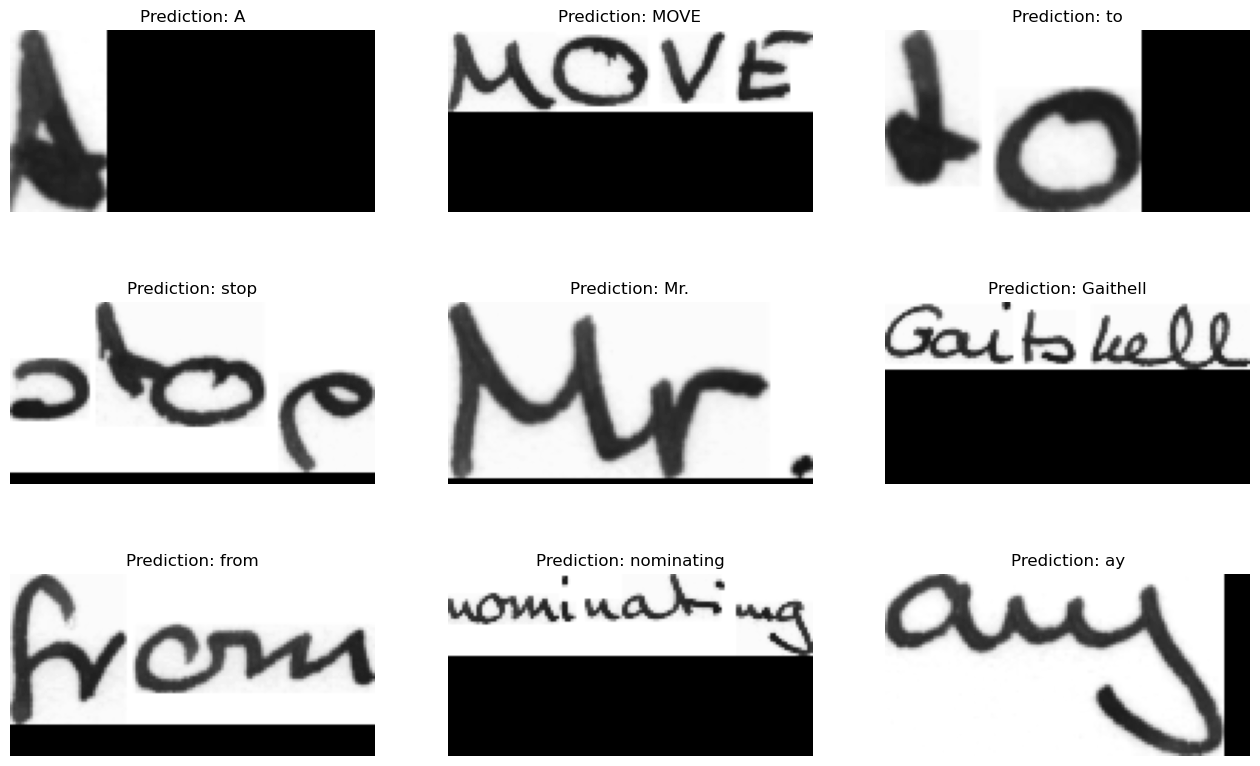

In [18]:
def decode_predictions(prediction):
    prediction_shape = prediction.shape
    input_len = np.ones(prediction_shape[0]) * prediction_shape[1]
    
    # todo: change - Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(prediction, input_length=input_len, greedy=True)[0][0][:, :22]
    # todo: change - Iterate over the results and get back the text.
    predicted_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        predicted_text.append(res)
    return predicted_text

# show images and their predicted text
for batch in prepared_training_dataset.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(3, 3, figsize=(16, 10))

    preds = final_prediction_model.predict(batch_images, verbose = 0)
    pred_texts = decode_predictions(preds)

    for i in range(9):
        axis = ax[i // 3, i % 3]
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])

        title = f"Prediction: {pred_texts[i]}"
        axis.axis("off")
        axis.imshow(img, cmap=plt.cm.gray)
        axis.set_title(title)

plt.show()

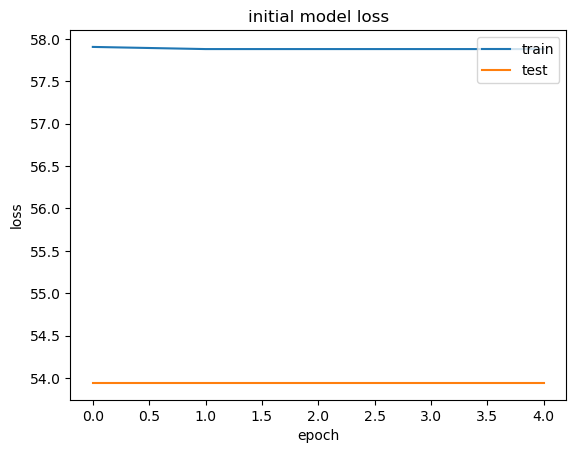

Initial model runtime: 450.61


In [19]:
# plot initial iteration loss
plt.plot(seq_history.history['loss'])
plt.plot(seq_history.history['val_loss'])
plt.title('initial model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

print(f"Initial model runtime: {seq_runtime}")

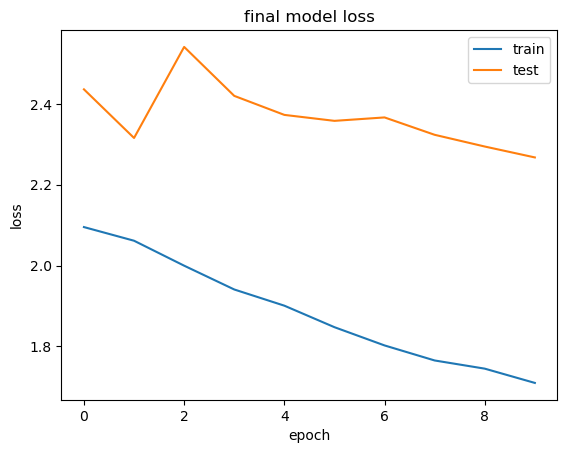

Final model runtime: 1362.8


In [20]:
# plot final iteration loss
plt.plot(final_history.history['loss'])
plt.plot(final_history.history['val_loss'])
plt.title('final model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

print(f"Final model runtime: {final_runtime}")

In [21]:
# prep functions for finding accuracy
correct_labels = []
for element in prepared_training_dataset.as_numpy_iterator(): 
    correct_labels.append(element["label"])
    

def uncode_labels(labels):
    uncoded_labels = []
    for label in labels:
        label = uncode_label(label)
        uncoded_labels.append(label)
    
    return uncoded_labels


def get_predicted_labels(i):
    # edge case for 0, nothing to skip
    if i == 0:
        for batch in prepared_training_dataset.take(1).prefetch(1):
            batch_images = batch["image"]
            preds = final_prediction_model.predict(batch_images, verbose = 0)
            pred_texts = decode_predictions(preds)
    else: 
        for batch in prepared_training_dataset.skip(i).take(1).prefetch(1):
            batch_images = batch["image"]
            preds = final_prediction_model.predict(batch_images, verbose = 0)
            pred_texts = decode_predictions(preds)
    
    return pred_texts

print("Original text:")
print(uncode_labels(correct_labels[0]))    
print("Predicted text:")
print(get_predicted_labels(0))

Original text:
['A', 'MOVE', 'to', 'stop', 'Mr.', 'Gaitskell', 'from', 'nominating', 'any', 'more', 'Labour', 'life', 'Peers', 'is', 'to', 'be', 'made', 'at', 'a', 'meeting', 'of', 'Labour', 'put', 'down', 'a', 'resolution', 'on', 'the', 'subject', 'Griffiths', ',', 'P']
Predicted text:
['A', 'MOVE', 'to', 'stop', 'Mr.', 'Gaithell', 'from', 'nominating', 'ay', 'mone', 'Labour', 'life', 'Peers', 'is', 'to', 'be', 'made', 'at', 'a', 'meeting', 'of', 'Labour', 'put', 'down', 'a', 'resoution', 'on', 'the', 'subject', 'oriftiths', ',', 'wp']


In [22]:
# Calculate accuracy -> if one character is off, it counts as the whole word being wrong (case-sensitive)
# improvement would be to use a distance metric
accuracy = 0
differences = 0
total = 0

# initialize vars for edit distance calculation
correct_list = []
predicted_list = []

for i in range(len(correct_labels)):
    correct_array = uncode_labels(correct_labels[i])
    predicted_array = get_predicted_labels(i)
    
    correct_list += correct_array
    predicted_list += predicted_array

    if len(correct_array) != len(predicted_array):
        continue
    else:
        total += len(correct_array)
        if (i % 200 == 0):
            print(f"Progress: {i}/{len(correct_labels)}")
        for j in range(len(correct_array)):
            if correct_array[j] != predicted_array[j]:
                differences += 1

print(f"Accuracy: {differences/total * 100}")

Progress: 0/2713
Progress: 200/2713
Progress: 400/2713
Progress: 600/2713
Progress: 800/2713
Progress: 1000/2713
Progress: 1200/2713
Progress: 1400/2713
Progress: 1600/2713
Progress: 1800/2713
Progress: 2000/2713
Progress: 2200/2713
Progress: 2400/2713
Progress: 2600/2713
Accuracy: 26.842838876153397


In [23]:
# Since accuracy is only looking at exact matches of the string, lets use edit distance to see how 
# far our model is off

def edit_distance(correct_list, predicted_list):
    distances = []
    total_distance = 0
    for i in range(len(correct_list)):
        word1 = correct_list[i]
        word2 = predicted_list[i]
        n = len(word1)
        m = len(word2)
        distance_matrix = np.zeros((n+1, m+1))
            
        for i in range(n+1):
            distance_matrix[i][0] = i
        for j in range(m+1):
            distance_matrix[0][j] = j
        for i in range(1, n+1):
            for j in range(1, m+1):
                if word1[i-1] == word2[j-1]:
                    distance_matrix[i][j] = distance_matrix[i-1][j-1]
                else:
                    distance_matrix[i][j] = 1 + min(distance_matrix[i][j-1], distance_matrix[i-1][j], distance_matrix[i-1][j-1])
        distance = distance_matrix[n][m]
        distances.append(distance)
        total_distance += distance
    mean_distance = total_distance / len(correct_list)
    return mean_distance

edit_distance(correct_list, predicted_list)

0.44044972295499313